In [32]:
import cobra
import pandas as pd
import importlib
import utils as u
import test_cutsets as tc
from itertools import combinations, combinations_with_replacement, permutations, chain, product
import pickle
from test_cutsets import itertools_product
from tqdm import tqdm

In [24]:
importlib.reload(tc)
importlib.reload(u)

<module 'utils' from '/home/jmuller/Documents/Stage_metabo/aspmcs/code/utils.py'>

### Loading results and decompressing cutsets reactions

In [20]:
# pour parse output de maxime
# ce que fait parse output = lit le csv, c'est a dire les reactions avec flux(R) > 0 (support(R))
# ce qu'affiche clingo: cutset(R) = support(R) & interest(R), interest(R) étant les reactions rsub mais pas tgt ni m000x
# func ici, ça recupere réactions interest(R)
func = lambda x: x.startswith('mcs_rsub') and not x.endswith('tgt')

In [3]:
comp_cs_list = u.parse_output("../../aspefm_mcs_checker/output_mcs_statin.txt")

In [4]:
decompressed_cs_list = u.decompress_cutsets("../new_reactionSubsets.txt", comp_cs_list)

In [5]:
model = cobra.io.read_sbml_model('../../models_storage/HepG2_medium.xml')

In [77]:
healthy = cobra.io.read_sbml_model("../../models_storage/iHep_updated_v011.xml")

In [78]:
healthy.optimize()

,fluxes,reduced_costs
HMR_3905,0.000000,-2.775558e-17
HMR_3907,0.000000,-2.775558e-17
HMR_4097,0.000000,-1.257395e-01
HMR_4099,0.000000,-1.257395e-01
HMR_4108,0.000000,-1.257395e-01
...,...,...
EX_m01451x,133.843432,0.000000e+00
HMR_9999,0.000000,0.000000e+00
EXR_m01965x,0.000000,0.000000e+00
EX_temp001x,165.033156,0.000000e+00


In [5]:
from collections import defaultdict

In [ ]:
reactions_count = {}
for reaction in model.reactions:
    reactions_count[reaction.id] = reactions_count.get(reaction.id, 0) + 1

In [6]:
decompressed_cs_list[5:]
subsystems = {}
subsystems2reacs = defaultdict(list)
for cutset in decompressed_cs_list[5:]:
    for decomp_reac in cutset:
        for reac_id in decomp_reac:
            if reac_id.endswith("_rev"):
                reac_id = reac_id[:-4]
            subsystems[model.reactions.get_by_id(reac_id).subsystem] = subsystems.get(model.reactions.get_by_id(reac_id).subsystem, 1) + 1
            subsystems2reacs[model.reactions.get_by_id(reac_id).subsystem].append(reac_id)
            #print(reac_id)

NameError: name 'model' is not defined

### glycogenesis 
HMR_9728

In [11]:
len(decompressed_cs_list[5:])

3

In [80]:
h_c = healthy.copy()

In [26]:
decompressed_cs_list_path = "../results/vanilla_run/res_final/merged_decompressed_cutsets.p"
with open(decompressed_cs_list_path, "rb") as input_mcs:
    decompressed_cs_list = pickle.load(input_mcs)

In [63]:
flat_list = [item for sublist in decompressed_cs_list for item in sublist]

In [65]:
len(flat_list)

14919

In [59]:
decompressed_cs_list

[[('EX_m02125x_rev',), ('HMR_9038',)],
 [('EX_m02993x_rev',), ('HMR_9044',)],
 [('HMR_1440', 'EX_temp006x'),
  ('HMR_1440', 'HMR_9736_rev'),
  ('HMR_1445', 'EX_temp006x'),
  ('HMR_1445', 'HMR_9736_rev'),
  ('HMR_1448_rev', 'EX_temp006x'),
  ('HMR_1448_rev', 'HMR_9736_rev'),
  ('HMR_1454', 'EX_temp006x'),
  ('HMR_1454', 'HMR_9736_rev'),
  ('HMR_1465_rev', 'EX_temp006x'),
  ('HMR_1465_rev', 'HMR_9736_rev'),
  ('HMR_1467', 'EX_temp006x'),
  ('HMR_1467', 'HMR_9736_rev'),
  ('HMR_1470', 'EX_temp006x'),
  ('HMR_1470', 'HMR_9736_rev'),
  ('HMR_1473', 'EX_temp006x'),
  ('HMR_1473', 'HMR_9736_rev'),
  ('HMR_1451', 'EX_temp006x'),
  ('HMR_1451', 'HMR_9736_rev'),
  ('HMR_1457', 'EX_temp006x'),
  ('HMR_1457', 'HMR_9736_rev'),
  ('HMR_1460', 'EX_temp006x'),
  ('HMR_1460', 'HMR_9736_rev')],
 [('HMR_3890', 'EX_m01975x_rev'), ('HMR_3890', 'HMR_9063')],
 [('HMR_1495', 'HMR_1496', 'HMR_1535', 'EX_temp006x'),
  ('HMR_1495', 'HMR_1496', 'HMR_1535', 'HMR_9736_rev'),
  ('HMR_1495', 'HMR_1496', 'HMR_1536', '

### Cell testinf every combination of every cutset

In [86]:
def test_cutsets_comb(decompressed_cs_list, model, objective, bounds_modifications = None):    
    i = 0
    invalid_cutsets_comb_index = []
    invalid_cutsets_index = {}
    fluxes_per_cs = []

    for cutset_reaction_combinations in tqdm(decompressed_cs_list):
        j = 0
        cs_fluxes = {}
        #For each combination of the cutset:
        for cutset_combination in cutset_reaction_combinations:
            #print("reactions_id: " + str(reactions_id))
            #reactions_bounds = []
            with model as model_buffer:
                for rid in cutset_combination:
                    #print("rid: "+str(rid))
                    if rid.endswith("rev"): 
                        rid = rid[:-4]
                    try:
                        #reactions_bounds.append(model_buffer.reactions.get_by_id(rid).bounds)
                        model_buffer.reactions.get_by_id(rid).bounds = (0.0,0.0)
                        
                    except KeyError:
                        pass
                model_buffer.objective = objective
                sol = model_buffer.optimize()
                if sol.objective_value > 1e-6:
                    #print(f"\nCutset {reactions_id} has no impact on neoglucogenesis")
                    pass
                else:
                    print(f"\nCutset {cutset_combination} prevents neoglucogenesis")
                    invalid_cutsets_comb_index.append(cutset_reaction_combinations.index(cutset_combination))
                for reaction in model_buffer.reactions:
                    cs_fluxes[reaction] = reaction.flux
                fluxes_per_cs.append(cs_fluxes)
                # for reaction in model.reactions:
                #     cs_fluxes[reaction] = reaction.fluxes

                #restoring bounds
                
        if len(invalid_cutsets_index) > 0:
            invalid_cutsets_index[decompressed_cs_list.index(cutset_reaction_combinations)] = invalid_cutsets_comb_index
        j+=1

    i+=1
    return invalid_cutsets_comb_index, fluxes_per_cs

### Testing only the first combination of every cutset

In [74]:

def test_cutsets(decompressed_cs_list, model, objective, bounds_modifications = None):
    i = 0
    invalid_cutsets_comb_index = []
    invalid_cutsets_index = {}
    fluxes_per_cs = []
    # Before anything, we copy the model, and apply the bounds changes if needed
    model_working_copy = model.copy()
    if bounds_modifications:
        for reaction, bounds in bounds_modifications:
            model_working_copy.reactions.get_by_id(reaction).bounds = bounds

    for cutset_reaction_combinations in tqdm(decompressed_cs_list):
        j = 0
        
        cs_fluxes = {}
        #Take the first cutset combination :
        cutset_combination = cutset_reaction_combinations[0]
  
        #reactions_bounds = []
        #modified_reactions_bounds = []
        with model as model_buffer:
            for rid in cutset_combination:
                
                #print("rid: "+str(rid))
                if rid.endswith("rev"): 
                    rid = rid[:-4]
                try:
                    #reactions_bounds.append(model_buffer.reactions.get_by_id(rid).bounds)
                    model_buffer.reactions.get_by_id(rid).bounds = (0.0,0.0)
                    
                except KeyError:
                    pass
            

            model_buffer.objective = objective
            sol = model_buffer.optimize()

            if sol.objective_value > 1e-6:
                #print(f"\nCutset {reactions_id} has no impact on neoglucogenesis")
                pass
            else:
                print(f"\nCutset {cutset_combination} prevents {objective}")
                invalid_cutsets_comb_index.append(cutset_reaction_combinations.index(cutset_combination))
        
            for reaction in model_buffer.reactions:
                cs_fluxes[reaction] = reaction.flux
            fluxes_per_cs.append(cs_fluxes)
        # #restoring bounds
        # for rid, rbounds in zip(cutset_combination, reactions_bounds):
        #     if rid.endswith("rev"):
        #         rid = rid[:-4]
        #     try:
        #         model.reactions.get_by_id(rid).bounds = rbounds
        #     except KeyError:
        #         pass
                
        if len(invalid_cutsets_comb_index) > 0:
            invalid_cutsets_index[decompressed_cs_list.index(cutset_reaction_combinations)] = invalid_cutsets_comb_index
        j+=1

    i+=1
    return invalid_cutsets_comb_index, fluxes_per_cs

invalid_cs_index, flux2cutset = test_cutsets(decompressed_cs_list, h_c,"HMR_9728")

 27%|██▋       | 234/870 [03:05<08:25,  1.26it/s]


KeyboardInterrupt: 

In [87]:
objective_reaction_list = ["biomass_components", "HMR_9728", "HMR_5401"]
objective2result = {}
for objective_reaction in objective_reaction_list:
    print(f"\nTesting Objective n°{objective_reaction_list.index(objective_reaction)+1}/{len(objective_reaction_list)}")
    invalid_cs_index, flux2cutset = test_cutsets_comb(decompressed_cs_list, h_c, objective_reaction)
    objective2result[objective_reaction] = (invalid_cs_index, flux2cutset)



Testing Objective n°1/3


  2%|▏         | 16/870 [03:44<1:13:30,  5.16s/it]

In [45]:
model.reactions.get_by_id("HMR_4075").subsystem

'Arginine and proline metabolism'

In [24]:
cutsets_list

[[('HMR_4693', 'HMR_3839', 'HMR_4437', 'EX_m02896x_rev', 'HMR_1440'),
  ('HMR_4693', 'HMR_3839', 'HMR_4437', 'EX_m02896x_rev', 'HMR_1445'),
  ('HMR_4693', 'HMR_3839', 'HMR_4437', 'EX_m02896x_rev', 'HMR_1448_rev'),
  ('HMR_4693', 'HMR_3839', 'HMR_4437', 'EX_m02896x_rev', 'HMR_1454'),
  ('HMR_4693', 'HMR_3839', 'HMR_4437', 'EX_m02896x_rev', 'HMR_1465_rev'),
  ('HMR_4693', 'HMR_3839', 'HMR_4437', 'EX_m02896x_rev', 'HMR_1467'),
  ('HMR_4693', 'HMR_3839', 'HMR_4437', 'EX_m02896x_rev', 'HMR_1470'),
  ('HMR_4693', 'HMR_3839', 'HMR_4437', 'EX_m02896x_rev', 'HMR_1473'),
  ('HMR_4693', 'HMR_3839', 'HMR_4437', 'EX_m02896x_rev', 'HMR_1451'),
  ('HMR_4693', 'HMR_3839', 'HMR_4437', 'EX_m02896x_rev', 'HMR_1457'),
  ('HMR_4693', 'HMR_3839', 'HMR_4437', 'EX_m02896x_rev', 'HMR_1460'),
  ('HMR_4693', 'HMR_3839', 'HMR_4437', 'HMR_9069', 'HMR_1440'),
  ('HMR_4693', 'HMR_3839', 'HMR_4437', 'HMR_9069', 'HMR_1445'),
  ('HMR_4693', 'HMR_3839', 'HMR_4437', 'HMR_9069', 'HMR_1448_rev'),
  ('HMR_4693', 'HMR_3839',

In [4]:
len(cutsets_list)

8

### Décompression des cutsets


In [6]:
model = cobra.io.read_sbml_model('../../models_storage/HepG2_medium.xml')
compressed_model = cobra.io.read_sbml_model("../new_reduced.xml")

Adding exchange reaction EX_ext_1 with default bounds for boundary metabolite: ext_1.
Adding exchange reaction EX_ext_10 with default bounds for boundary metabolite: ext_10.
Adding exchange reaction EX_ext_11 with default bounds for boundary metabolite: ext_11.
Adding exchange reaction EX_ext_12 with default bounds for boundary metabolite: ext_12.
Adding exchange reaction EX_ext_13 with default bounds for boundary metabolite: ext_13.
Adding exchange reaction EX_ext_14 with default bounds for boundary metabolite: ext_14.
Adding exchange reaction EX_ext_15 with default bounds for boundary metabolite: ext_15.
Adding exchange reaction EX_ext_16 with default bounds for boundary metabolite: ext_16.
Adding exchange reaction EX_ext_17 with default bounds for boundary metabolite: ext_17.
Adding exchange reaction EX_ext_18 with default bounds for boundary metabolite: ext_18.
Adding exchange reaction EX_ext_19 with default bounds for boundary metabolite: ext_19.
Adding exchange reaction EX_ext_2 

### Testing cutsets on compressed model

In [19]:
print(u.sol_after_ko(["rsub_166","rsub_409", "rsub_419", "rsub_77", "rsub_844"],compressed_model, "rsub_93"))

0.0


In [17]:
for cs in cutsets_list:
    cs_names = []
    for rname in cs:
        if "mcs" in rname:
            new_rname = rname[4:]
        if "rev" in rname: 
            new_rname = rname[:-4]
        cs_names.append(new_rname)
    sol = u.sol_after_ko(cs_names, compressed_model, "rsub_93")
    print(sol, cs_names)

0.0 ['rsub_844', 'rsub_94']
22.35605780573477 ['mcs_rsub_1084', 'rsub_844']
0.0 ['rsub_59', 'rsub_844']
0.0 ['rsub_2114', 'rsub_844']
0.0 ['rsub_2108', 'rsub_844']
0.0 ['rsub_384', 'rsub_409', 'rsub_419', 'rsub_77', 'rsub_844']
0.0 ['rsub_166', 'rsub_409', 'rsub_419', 'rsub_77', 'rsub_844']
0.0 ['rsub_387', 'rsub_409', 'rsub_419', 'rsub_77', 'rsub_844']


In [8]:
with open("../new_reactionSubsets.txt", 'r') as buffer_subsets:
    reaction_subsets_dict = eval(buffer_subsets.read())
listofcutsets_original_id = []
for reac_list in cutsets_list:
    #Pour chaque cutset:

    cutset_original_IDs = []
    #print(f"\n\nFor cutset {reac_list}:\n\n")
    for comp_reac_id in reac_list:
        #Pour chaque réaction compressée du cutset
        #On veut récupérer le subset de réactions pré-compression.
        reac_subset = reaction_subsets_dict[comp_reac_id[4:]]["reacs"]
        cutset_original_IDs.append(reac_subset)
    listofcutsets_original_id.append(cutset_original_IDs)

In [9]:
listofcutsets_original_id

[[['HMR_1440',
   'HMR_1445',
   'HMR_1448_rev',
   'HMR_1454',
   'HMR_1465_rev',
   'HMR_1467',
   'HMR_1470',
   'HMR_1473',
   'HMR_1451',
   'HMR_1457',
   'HMR_1460'],
  ['EX_temp006x', 'HMR_9736_rev']],
 [['HMR_0018_rev'],
  ['HMR_1440',
   'HMR_1445',
   'HMR_1448_rev',
   'HMR_1454',
   'HMR_1465_rev',
   'HMR_1467',
   'HMR_1470',
   'HMR_1473',
   'HMR_1451',
   'HMR_1457',
   'HMR_1460']],
 [['EX_m02352x', 'EX_m02353x_rev', 'HMR_0014', 'HMR_0019'],
  ['HMR_1440',
   'HMR_1445',
   'HMR_1448_rev',
   'HMR_1454',
   'HMR_1465_rev',
   'HMR_1467',
   'HMR_1470',
   'HMR_1473',
   'HMR_1451',
   'HMR_1457',
   'HMR_1460']],
 [['HMR_9055'],
  ['HMR_1440',
   'HMR_1445',
   'HMR_1448_rev',
   'HMR_1454',
   'HMR_1465_rev',
   'HMR_1467',
   'HMR_1470',
   'HMR_1473',
   'HMR_1451',
   'HMR_1457',
   'HMR_1460']],
 [['HMR_9027'],
  ['HMR_1440',
   'HMR_1445',
   'HMR_1448_rev',
   'HMR_1454',
   'HMR_1465_rev',
   'HMR_1467',
   'HMR_1470',
   'HMR_1473',
   'HMR_1451',
   'HMR_14

In [60]:
model.objective = "biomass_components"

In [11]:
tc.itertools_product(listofcutsets_original_id, model)

  8%|▊         | 2/25 [32:31<6:14:02, 975.76s/it]


KeyboardInterrupt: 

In [11]:
with open("../new_reactionSubsets.txt", 'r') as buffer_subsets:
    reaction_subsets_dict = eval(buffer_subsets.read())
listofcutsets_original_id = []
for reac_list in cutsets_list:
    #Pour chaque cutset:

    cutset_original_IDs = []
    #print(f"\n\nFor cutset {reac_list}:\n\n")
    for comp_reac_id in reac_list:
        #Pour chaque réaction compressée du cutset
        #On veut récupérer le subset de réactions pré-compression.
        reac_subset = reaction_subsets_dict[comp_reac_id[4:]]["reacs"]
        cutset_original_IDs.append(reac_subset)
    listofcutsets_original_id.append(cutset_original_IDs)
    
        #cutset_original_IDs est une liste de même taille que reac_list,
        #mais dont les éléments sont des listes de réactions qui sont 
        #les subsets de réaction pré-compression
i = 1
for cutset_orID in listofcutsets_original_id:
    #print(f"Cutset : {cutset_orID}\n")
    combinations = list(product(*cutset_orID))
    for comb in combinations:
        with model as m:
            retval = u.sol_after_ko(comb, m)
            # for reac in cs:
            #     m.reactions.get_by_id(reac.strip("_rev"))
            #opt = m.optimize()
        #print("<",opt.objective_value,">", cs )
        if retval < 1e-6:
            print("Obj_value = ",retval,"For cutset >>>", comb )
        else:
            print(f"{cs_comb} is not a cutset.")

        if len(comb) > 1 :
            for nm1 in combinations(comb, len(cs)-1):
                #with model as m:
                #    for reac in nm1:
                #        m.reactions.get_by_id(reac.strip("_rev")).knock_out()
                #    opt = m.optimize()
                #print('N-1',"<", opt.objective_value,">", nm1, 'not MIN cutset' if opt.objective_value < 1e-6 else '')
                retval = u.sol_after_ko(nm1, m)
                print('[N-1]',"Objective value = ", retval,"For n-1 subset of cutset >>>", nm1, 'not MIN cutset' if retval < 1e-6 else '')
    i+=1
    #print(f"comb : {combinations}\n")

Obj_value =  0.0 For cutset >>> ('HMR_3258',)
Obj_value =  0.0 For cutset >>> ('HMR_3260',)
Obj_value =  0.0 For cutset >>> ('HMR_3262',)
Obj_value =  0.0 For cutset >>> ('HMR_3264',)
Obj_value =  0.0 For cutset >>> ('HMR_3272_rev',)
Obj_value =  0.0 For cutset >>> ('HMR_2211', 'HMR_2626', 'HMR_2654', 'HMR_3121')


NameError: name 'cs' is not defined

In [ ]:
nlist = [[i,j,k] for i in liste[0] for j in liste[1] for k in liste[2]]

In [31]:
def decompress_cutsets(subsets_file_path, comp_cutsets_list):
    with open(subsets_file_path, 'r') as buffer_subsets:
        reaction_subsets_dict = eval(buffer_subsets.read())

    decomp_cutsets_list = []
    for reac_list in comp_cutsets_list:
        #Itère sur chaque cutset

        cs_decomp = []
        cs_decomp_comb = []
        for reac in reac_list:
            reac_id = reac[4:]
            original_reac_subset = reaction_subsets_dict[reac_id]["reacs"]
            cs_decomp.append(original_reac_subset)
        
        for cutset_subset in cs_decomp:
            
            for comb in combinations(cutset_subset, len(reac_list)):
                
                cs_decomp_comb.append(comb)
        decomp_cutsets_list.append(cs_decomp_comb)
            
    return decomp_cutsets_list

In [32]:
decomp_cutsets_list = decompress_cutsets("../new_reactionSubsets.txt", cutsets_list)

In [6]:
cutsets_list

[['mcs_rsub_831'],
 ['mcs_rsub_169', 'mcs_rsub_439', 'mcs_rsub_625', 'mcs_rsub_75'],
 ['mcs_rsub_749_rev', 'mcs_rsub_750', 'mcs_rsub_751', 'mcs_rsub_752'],
 ['mcs_rsub_750', 'mcs_rsub_751', 'mcs_rsub_752', 'mcs_rsub_820'],
 ['mcs_rsub_547', 'mcs_rsub_75'],
 ['mcs_rsub_1102'],
 ['mcs_rsub_418',
  'mcs_rsub_443',
  'mcs_rsub_445',
  'mcs_rsub_488',
  'mcs_rsub_547'],
 ['mcs_rsub_418', 'mcs_rsub_436', 'mcs_rsub_443', 'mcs_rsub_547'],
 ['mcs_rsub_418',
  'mcs_rsub_436',
  'mcs_rsub_444',
  'mcs_rsub_483',
  'mcs_rsub_547'],
 ['mcs_rsub_747'],
 ['mcs_rsub_821']]

In [33]:
decomp_cutsets_list

[[('HMR_3258',),
  ('HMR_3260',),
  ('HMR_3262',),
  ('HMR_3264',),
  ('HMR_3272_rev',)],
 [('HMR_2254', 'HMR_2255', 'HMR_2256', 'HMR_2257'),
  ('HMR_2254', 'HMR_2255', 'HMR_2256', 'HMR_2258'),
  ('HMR_2254', 'HMR_2255', 'HMR_2257', 'HMR_2258'),
  ('HMR_2254', 'HMR_2256', 'HMR_2257', 'HMR_2258'),
  ('HMR_2255', 'HMR_2256', 'HMR_2257', 'HMR_2258')],
 [('HMR_2611', 'HMR_2612_rev', 'HMR_2613_rev', 'HMR_3398')],
 [('HMR_2611', 'HMR_2612_rev', 'HMR_2613_rev', 'HMR_3398'),
  ('HMR_3128', 'HMR_3129', 'HMR_3130', 'HMR_3132')],
 [('EX_m02772x', 'HMR_9808_rev')],
 [('HMR_0225',)],
 [],
 [('HMR_3206', 'HMR_3778', 'HMR_3785', 'HMR_3823'),
  ('HMR_3206', 'HMR_3778', 'HMR_3785', 'HMR_5107'),
  ('HMR_3206', 'HMR_3778', 'HMR_3823', 'HMR_5107'),
  ('HMR_3206', 'HMR_3785', 'HMR_3823', 'HMR_5107'),
  ('HMR_3778', 'HMR_3785', 'HMR_3823', 'HMR_5107')],
 [('HMR_3206', 'HMR_3778', 'HMR_3785', 'HMR_3823', 'HMR_5107')],
 [('HMR_2602_rev',), ('HMR_2603_rev',), ('HMR_2604',)],
 [('HMR_3135',)]]

### Models loading

In [8]:
model = cobra.io.read_sbml_model('../HepG2_medium.xml')
compressed_model = cobra.io.read_sbml_model("../new_reduced.xml")

Adding exchange reaction EX_ext_1 with default bounds for boundary metabolite: ext_1.
Adding exchange reaction EX_ext_10 with default bounds for boundary metabolite: ext_10.
Adding exchange reaction EX_ext_11 with default bounds for boundary metabolite: ext_11.
Adding exchange reaction EX_ext_12 with default bounds for boundary metabolite: ext_12.
Adding exchange reaction EX_ext_13 with default bounds for boundary metabolite: ext_13.
Adding exchange reaction EX_ext_14 with default bounds for boundary metabolite: ext_14.
Adding exchange reaction EX_ext_15 with default bounds for boundary metabolite: ext_15.
Adding exchange reaction EX_ext_16 with default bounds for boundary metabolite: ext_16.
Adding exchange reaction EX_ext_17 with default bounds for boundary metabolite: ext_17.
Adding exchange reaction EX_ext_18 with default bounds for boundary metabolite: ext_18.
Adding exchange reaction EX_ext_19 with default bounds for boundary metabolite: ext_19.
Adding exchange reaction EX_ext_2 

In [7]:
compressed_model.objective = "rsub_2116"
model.objective = 'biomass_components'

### Testing cutsets on original model with combinations of reactions from compressed cutsets
Each compressed cutset has one reaction from its reactions subset in each cs_comb.

In [19]:
i = 1
for cs in decomp_cutsets_list:
    print(f"\nCUTSET N° {i} : {cutsets_list[i-1]}\n\n")
    for cs_comb in cs:
        
        with model as m:
            retval = sol_after_ko(cs_comb, m)
            # for reac in cs:
            #     m.reactions.get_by_id(reac.strip("_rev"))
            #opt = m.optimize()
        #print("<",opt.objective_value,">", cs )
        if retval < 1e-6:
            print("Obj_value = ",retval,"For cutset >>>", cs_comb )
        else:
            print(f"{cs_comb} is not a cutset.")

        if len(cs_comb) > 1 :
            for nm1 in combinations(cs_comb, len(cs)-1):
                #with model as m:
                #    for reac in nm1:
                #        m.reactions.get_by_id(reac.strip("_rev")).knock_out()
                #    opt = m.optimize()
                #print('N-1',"<", opt.objective_value,">", nm1, 'not MIN cutset' if opt.objective_value < 1e-6 else '')
                retval = sol_after_ko(nm1, m)
                print('[N-1]',"Objective value = ", retval,"For n-1 subset of cutset >>>", nm1, 'not MIN cutset' if retval < 1e-6 else '')
    i+=1


CUTSET N° 1 : ['mcs_rsub_831']


Obj_value =  0.0 For cutset >>> ('HMR_3258',)
Obj_value =  0.0 For cutset >>> ('HMR_3260',)
Obj_value =  0.0 For cutset >>> ('HMR_3262',)
Obj_value =  0.0 For cutset >>> ('HMR_3264',)
Obj_value =  0.0 For cutset >>> ('HMR_3272_rev',)

CUTSET N° 2 : ['mcs_rsub_169', 'mcs_rsub_439', 'mcs_rsub_625', 'mcs_rsub_75']


('HMR_2254', 'HMR_2255', 'HMR_2256', 'HMR_2257') is not a cutset.
('HMR_2254', 'HMR_2255', 'HMR_2256', 'HMR_2258') is not a cutset.
('HMR_2254', 'HMR_2255', 'HMR_2257', 'HMR_2258') is not a cutset.
('HMR_2254', 'HMR_2256', 'HMR_2257', 'HMR_2258') is not a cutset.
('HMR_2255', 'HMR_2256', 'HMR_2257', 'HMR_2258') is not a cutset.
('HMR_2254', 'HMR_2255', 'HMR_2256', 'HMR_2257') is not a cutset.
('HMR_2254', 'HMR_2255', 'HMR_2256', 'HMR_2258') is not a cutset.
('HMR_2254', 'HMR_2255', 'HMR_2257', 'HMR_2258') is not a cutset.
('HMR_2254', 'HMR_2256', 'HMR_2257', 'HMR_2258') is not a cutset.
('HMR_2255', 'HMR_2256', 'HMR_2257', 'HMR_2258') is not a

KeyboardInterrupt: 

### Testing by grouping reactions from cutsets

In [12]:
with open("../new_reactionSubsets.txt", 'r') as buffer_subsets:
    reaction_subsets_dict = eval(buffer_subsets.read())

In [13]:
grouped_cutsets_list = []
grouped_cutsets_list_decomp = []
for cutset in cutsets_list:
    cutset_decomp = []
    for rid in cutset:
        reaction_id = rid[4:]
        original_ids = reaction_subsets_dict[reaction_id]["reacs"]
        cutset_decomp += original_ids
    
    grouped_cutsets_list_decomp.append(cutset_decomp)


In [16]:
grouped_cutsets_list_decomp

[['HMR_3258', 'HMR_3260', 'HMR_3262', 'HMR_3264', 'HMR_3272_rev'],
 ['HMR_4497',
  'HMR_4741',
  'HMR_4735',
  'HMR_3213',
  'HMR_2254',
  'HMR_2255',
  'HMR_2256',
  'HMR_2257',
  'HMR_2258',
  'EX_m02772x',
  'HMR_9808_rev'],
 ['HMR_2608_rev',
  'HMR_2609_rev',
  'HMR_2610',
  'HMR_2611',
  'HMR_2612_rev',
  'HMR_2613_rev',
  'HMR_3398',
  'HMR_2614',
  'HMR_2616_rev',
  'HMR_2618_rev',
  'HMR_2620',
  'HMR_2621_rev',
  'HMR_2622_rev'],
 ['HMR_2611',
  'HMR_2612_rev',
  'HMR_2613_rev',
  'HMR_3398',
  'HMR_2614',
  'HMR_2616_rev',
  'HMR_2618_rev',
  'HMR_2620',
  'HMR_2621_rev',
  'HMR_2622_rev',
  'HMR_3128',
  'HMR_3129',
  'HMR_3130',
  'HMR_3132'],
 ['HMR_3977', 'EX_m02772x', 'HMR_9808_rev'],
 ['HMR_0225'],
 ['HMR_8442', 'HMR_3795', 'HMR_6419', 'HMR_6420', 'HMR_3780', 'HMR_3977'],
 ['HMR_8442',
  'HMR_3206',
  'HMR_3778',
  'HMR_3785',
  'HMR_3823',
  'HMR_5107',
  'HMR_3795',
  'HMR_3977'],
 ['HMR_8442',
  'HMR_3206',
  'HMR_3778',
  'HMR_3785',
  'HMR_3823',
  'HMR_5107',
  'H

In [18]:
i = 1
for cs in grouped_cutsets_list_decomp:
    print(f"\nCUTSET N° {i} : {cutsets_list[i-1]}\n\n")
    
        
    with model as m:
        retval = sol_after_ko(cs, m)
        # for reac in cs:
        #     m.reactions.get_by_id(reac.strip("_rev"))
        #opt = m.optimize()
    #print("<",opt.objective_value,">", cs )
    if retval < 1e-6:
        print("Obj_value = ",retval,"For cutset >>>", cs )
    else:
        print(f"{cs} is not a cutset.")

    if len(cs) > 1 :
        for nm1 in combinations(cs, len(cs)-1):
            #with model as m:
            #    for reac in nm1:
            #        m.reactions.get_by_id(reac.strip("_rev")).knock_out()
            #    opt = m.optimize()
            #print('N-1',"<", opt.objective_value,">", nm1, 'not MIN cutset' if opt.objective_value < 1e-6 else '')
            retval = sol_after_ko(nm1, m)
            print('[N-1]',"Objective value = ", retval,"For n-1 subset of cutset >>>", nm1, 'not MIN cutset' if retval < 1e-6 else '')
    i+=1


CUTSET N° 1 : ['mcs_rsub_831']


Obj_value =  0.0 For cutset >>> ['HMR_3258', 'HMR_3260', 'HMR_3262', 'HMR_3264', 'HMR_3272_rev']
[N-1] Objective value =  0.0 For n-1 subset of cutset >>> ('HMR_3258', 'HMR_3260', 'HMR_3262', 'HMR_3264') not MIN cutset
[N-1] Objective value =  0.0 For n-1 subset of cutset >>> ('HMR_3258', 'HMR_3260', 'HMR_3262', 'HMR_3272_rev') not MIN cutset
[N-1] Objective value =  0.0 For n-1 subset of cutset >>> ('HMR_3258', 'HMR_3260', 'HMR_3264', 'HMR_3272_rev') not MIN cutset
[N-1] Objective value =  0.0 For n-1 subset of cutset >>> ('HMR_3258', 'HMR_3262', 'HMR_3264', 'HMR_3272_rev') not MIN cutset
[N-1] Objective value =  0.0 For n-1 subset of cutset >>> ('HMR_3260', 'HMR_3262', 'HMR_3264', 'HMR_3272_rev') not MIN cutset

CUTSET N° 2 : ['mcs_rsub_169', 'mcs_rsub_439', 'mcs_rsub_625', 'mcs_rsub_75']


Obj_value =  0.0 For cutset >>> ['HMR_4497', 'HMR_4741', 'HMR_4735', 'HMR_3213', 'HMR_2254', 'HMR_2255', 'HMR_2256', 'HMR_2257', 'HMR_2258', 'EX_m02772x', 'HMR_98

In [67]:
from aspmcs.code.utils import knock_out

## Cutsets

In [40]:
with open("../results/good_cutsets_list.p", "rb") as in_cutsets:
    cutsets_list = pickle.load(in_cutsets) 

In [23]:
model.objective = "HMR_7869"

In [79]:
model.reactions.HMR_7869

Reaction identifier,HMR_7869
Name,CMPK1
Memory address,0x7f733b851120
Stoichiometry,m01637c + m03106c <=> m01642c + m03114c dADP + UDP <=> dATP + UMP
GPR,ENSG00000162368
Lower bound,-1000.0
Upper bound,1000.0


In [76]:
model.metabolites.get_by_id("m01642c")

Metabolite identifier,m01642c
Name,dATP
Memory address,0x7f733d85d1b0
Formula,C10H16N5O12P3
Compartment,C_c
In 19 reaction(s),"HMR_4493, HMR_7160, HMR_4044, HMR_7869, HMR_7830, HMR_7853, HMR_4489, HMR_4487, HMR_6341, HMR_7839, HMR_7848, HMR_6614, HMR_8469, HMR_4496, HMR_4421, HMR_7854, HMR_8454, HMR_6338, HMR_4611"


In [ ]:
for m in model.meta

In [28]:
model.reactions.get_by_id("HMR_7160").bounds = (0.0,1000.0)
model.optimize()

,fluxes,reduced_costs
EX_m00097x,129.460433,0.0
EX_m00157x,-0.000000,0.0
EX_m00228x,0.000000,0.0
EX_m00242x,0.000000,0.0
EX_m00266x,-0.000000,0.0
...,...,...
HMR_9695,0.000000,0.0
HMR_9715,0.000000,0.0
HMR_9730,0.000000,0.0
HMR_9736,-243.042741,0.0


In [31]:
for cutset_comb in cutsets_list:
    for reaction_to_cut in cutset_comb:
        print(reaction_to_cut)
        obj_val = u.sol_after_ko(list(reaction_to_cut), model, "biomass_components", "HMR_7160")

        print(obj_val)

('HMR_4038',)
Reaction HMR_7160 : flux = 1000.0
0.0
('HMR_4406',)
Reaction HMR_7160 : flux = 1000.0
0.0
('HMR_4799',)
Reaction HMR_7160 : flux = 1000.0
0.0
('HMR_4802',)
Reaction HMR_7160 : flux = 1000.0
0.0
('HMR_4804_rev',)
Reaction HMR_7160 : flux = 1000.0
0.0
('HMR_4808',)
Reaction HMR_7160 : flux = 1000.0
0.0
('HMR_4810',)
Reaction HMR_7160 : flux = 1000.0
0.0
('HMR_4812_rev',)
Reaction HMR_7160 : flux = 1000.0
0.0
('HMR_4814',)


KeyboardInterrupt: 

In [39]:
import matplotlib.pyplot as plt

In [40]:
compressed_cutsets_run1 = u.parse_output("../results/vanilla_run/output_mcs_vanilla_1.txt")
compressed_cutsets_run2 = u.parse_output("../results/vanilla_run/output_mcs_vanilla_2.txt")
compressed_cutsets_run3 = u.parse_output("../results/vanilla_run/output_mcs_vanilla_3.txt")

In [41]:
len_cutsets_counter_dict = {}
compressed_cutsets_no_dup = []
for cutset in compressed_cutsets_run1:
    if cutset in compressed_cutsets_no_dup:
        continue
    else:
        compressed_cutsets_no_dup.append(cutset)

for cutset in compressed_cutsets_no_dup:
    len_cutsets_counter_dict[len(cutset)] = len_cutsets_counter_dict.get(len(cutset), 0) + 1

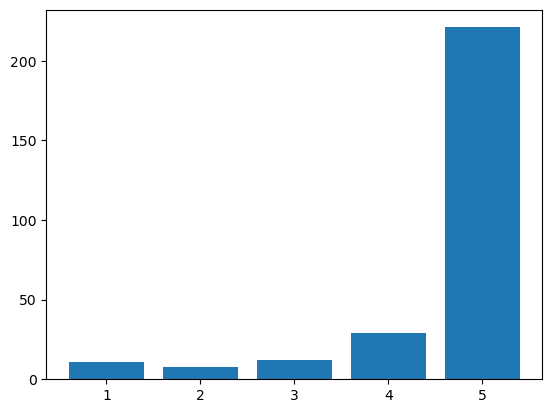

In [49]:
# Compressé
x = len_cutsets_counter_dict.keys()
y = len_cutsets_counter_dict.values()

fig, ax = plt.subplots()
ax.bar(x, y)
plt.show()

In [67]:
len_cutsets_counter_dict_decomp = {}
for cutset in flat_list:
    len_cutsets_counter_dict_decomp[len(cutset)] = len_cutsets_counter_dict_decomp.get(len(cutset), 0) + 1

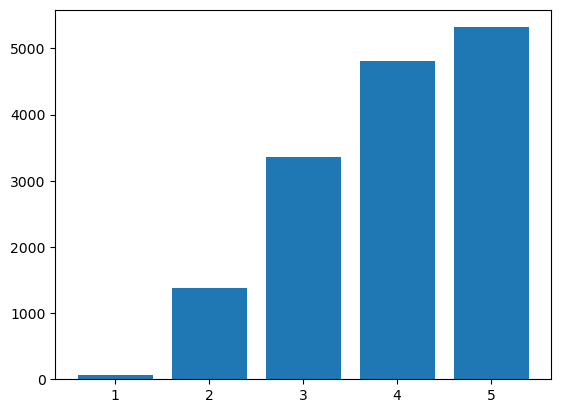

In [68]:
# Décompressé
x = len_cutsets_counter_dict_decomp.keys()
y = len_cutsets_counter_dict_decomp.values()

fig, ax = plt.subplots()
ax.bar(x, y)
plt.show()